# Northern Portuguese Red Wine Quality Classification

Data is from the UC Irvine Machine Learning Repository : https://archive.ics.uci.edu/dataset/186/wine+quality

### Import Required Libraries

We start by importing various required (probably some unnecessary libraries are included here..) libraries for the notebook.

In [152]:
import math
from math import exp
import pickle
import gzip
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pylab as plt
from matplotlib.colors import Normalize
import seaborn as sns
import collections
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from statsmodels.tsa.ar_model import AutoReg
from sklearn.neighbors import KNeighborsClassifier
from mpl_toolkits import mplot3d
from sklearn.svm import SVC
from sklearn.base import clone 

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, ConfusionMatrixDisplay, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, KFold, train_test_split, StratifiedKFold

### Import the Data and Peek

Now let's import the data and take a peek using the head() and info() methods.

In [153]:
model_data = pd.read_csv('winequality-red.csv', sep = ';') 
print(model_data.head())
model_data.info()

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

### Summary Statistics

Now let's use the describe() method to take a look at summary statistics. This will mainly reveal varying scales for our features, highlighting the importance of normalization prior to traning our models (i.e., imagine a KNN model on the raw data where the distance metric is dominated by the total sulfur dioxide feature!)

In [154]:
model_data.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             22.000000     0.995600   
50%       0.079000            14.000000             38.000000     0.996750   
75%       0.090000            21.000000             62.000000     0.997835   
max       0.611000            72.000000            289.000000     1.003690   

                pH    sulphates      alcohol      quality  
count  1599.000000  1599.000000  1599.000000  1599.000000  
mean      3.311113     0.658149    10.422983     5.636023  
std       0.154386     0.169507     1.065668     0.807569  
min       2.740000     0.330000     8.400000     3.000000  
25%       3.210000     0.550000     9.500000     5.000000  
50%       3.310000     0.620000    10.200000     6.000000  
75%       3.400000     0.730000    11.100000     6.000000  
max       4.010000     2.000000    14.900000     8.000000

### Target Values Histogram

Now let's take a look at a histogram of our target variable, a wine quality score. We saw above in the summary statistics that this variable ranges from 3 to 8, with a median of 6, and an average also near 6. However, as shown here, we are dealing with seriously imbalanced data here, with the overwhelming majority of target values being either 5 or 6. This fact of heavily imbalanced data will significantly influence how we handle our modeling moving forward. Also, we need to keep this in mind when assessing our models relative to just a random guess. With perfectly balanced data, a random guess would be 1/6, or about 16%. However, we need to note here that just randomly guessing either 5 or 6 would lead to a model with something more like 40% accuracy, so we should base our expectations around here instead.

Text(0.5, 1.0, 'Red Wine Quality Scores Histogram')

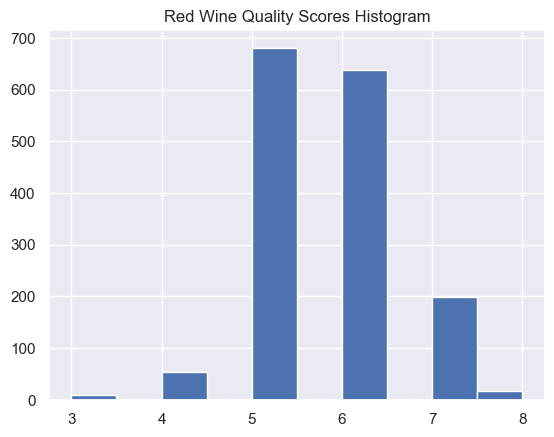

In [155]:
plt.hist(model_data['quality'])
plt.title("Red Wine Quality Scores Histogram")

### Feature Correlation Matrix

Now let's take a look at the correlation amongst features. All the features, unlike the target, are real-valued and so correlations will have their typical interpretation, although the features likely have natural boundaries given they are physical properties. Some suspected collinearity amongst features will be handled in subsequent data cleaning. 

[Text(0.5, 1, 'fixed acidity'),
 Text(1.5, 1, 'volatile acidity'),
 Text(2.5, 1, 'citric acid'),
 Text(3.5, 1, 'residual sugar'),
 Text(4.5, 1, 'chlorides'),
 Text(5.5, 1, 'free sulfur dioxide'),
 Text(6.5, 1, 'total sulfur dioxide'),
 Text(7.5, 1, 'density'),
 Text(8.5, 1, 'pH'),
 Text(9.5, 1, 'sulphates'),
 Text(10.5, 1, 'alcohol')]

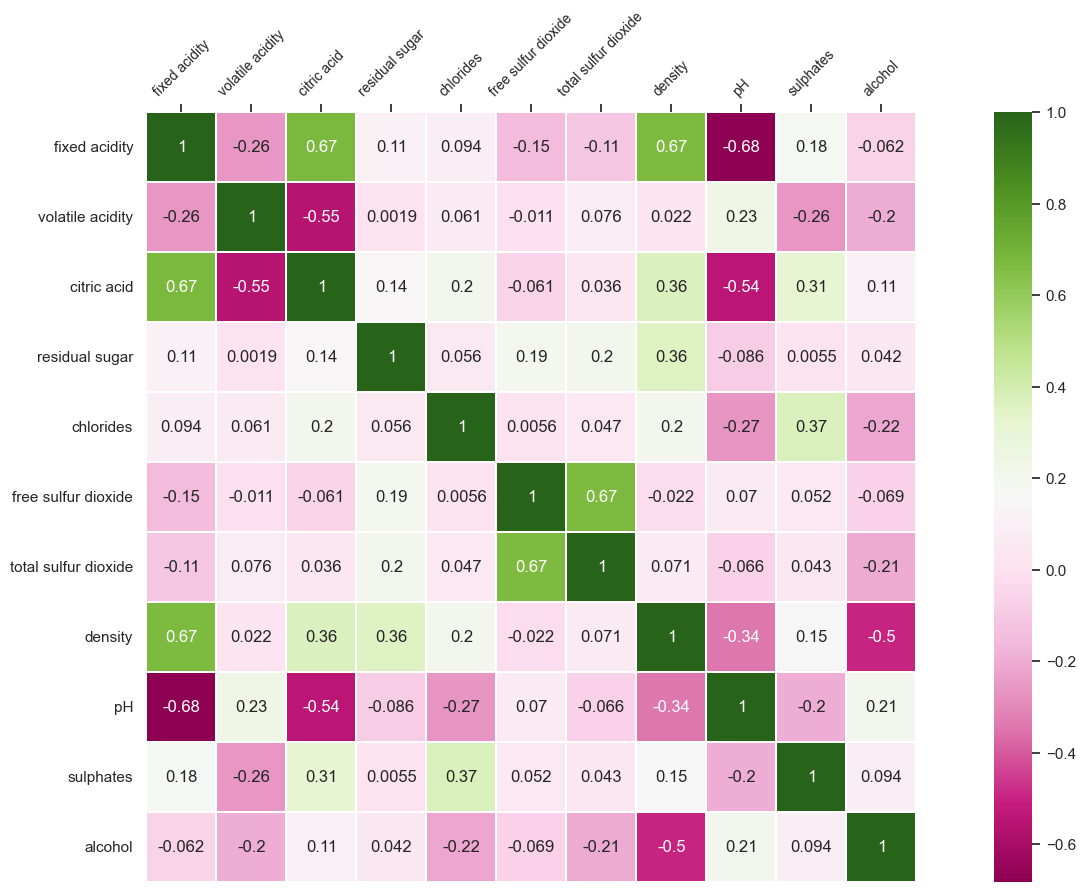

In [156]:
plt.figure(figsize = (20,10))
sns.set(font_scale=1)
ax = sns.heatmap(model_data.drop(columns=['quality']).corr(), annot=True, cmap="PiYG", annot_kws={"size":12}, square=True, 
        linewidths=0.1)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 10)

### Feature Pair Plot

Now let's take a look at a pair plot of the features. The off-diagonal plots will reveal similar inferences to the correlation matrix above. The diagonal elements will reveal that many of our features are right-skewed, which may make sense as we are dealing with physical quantities. Although we will not be running models which tend to require adjusting for this skew, i.e. linear regression, and will instead rely on models more sensitive to min-max normlization, we will still likely log-correct these features in the data cleaning step for means of thoroughness.

C:\Program Files\Python39\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


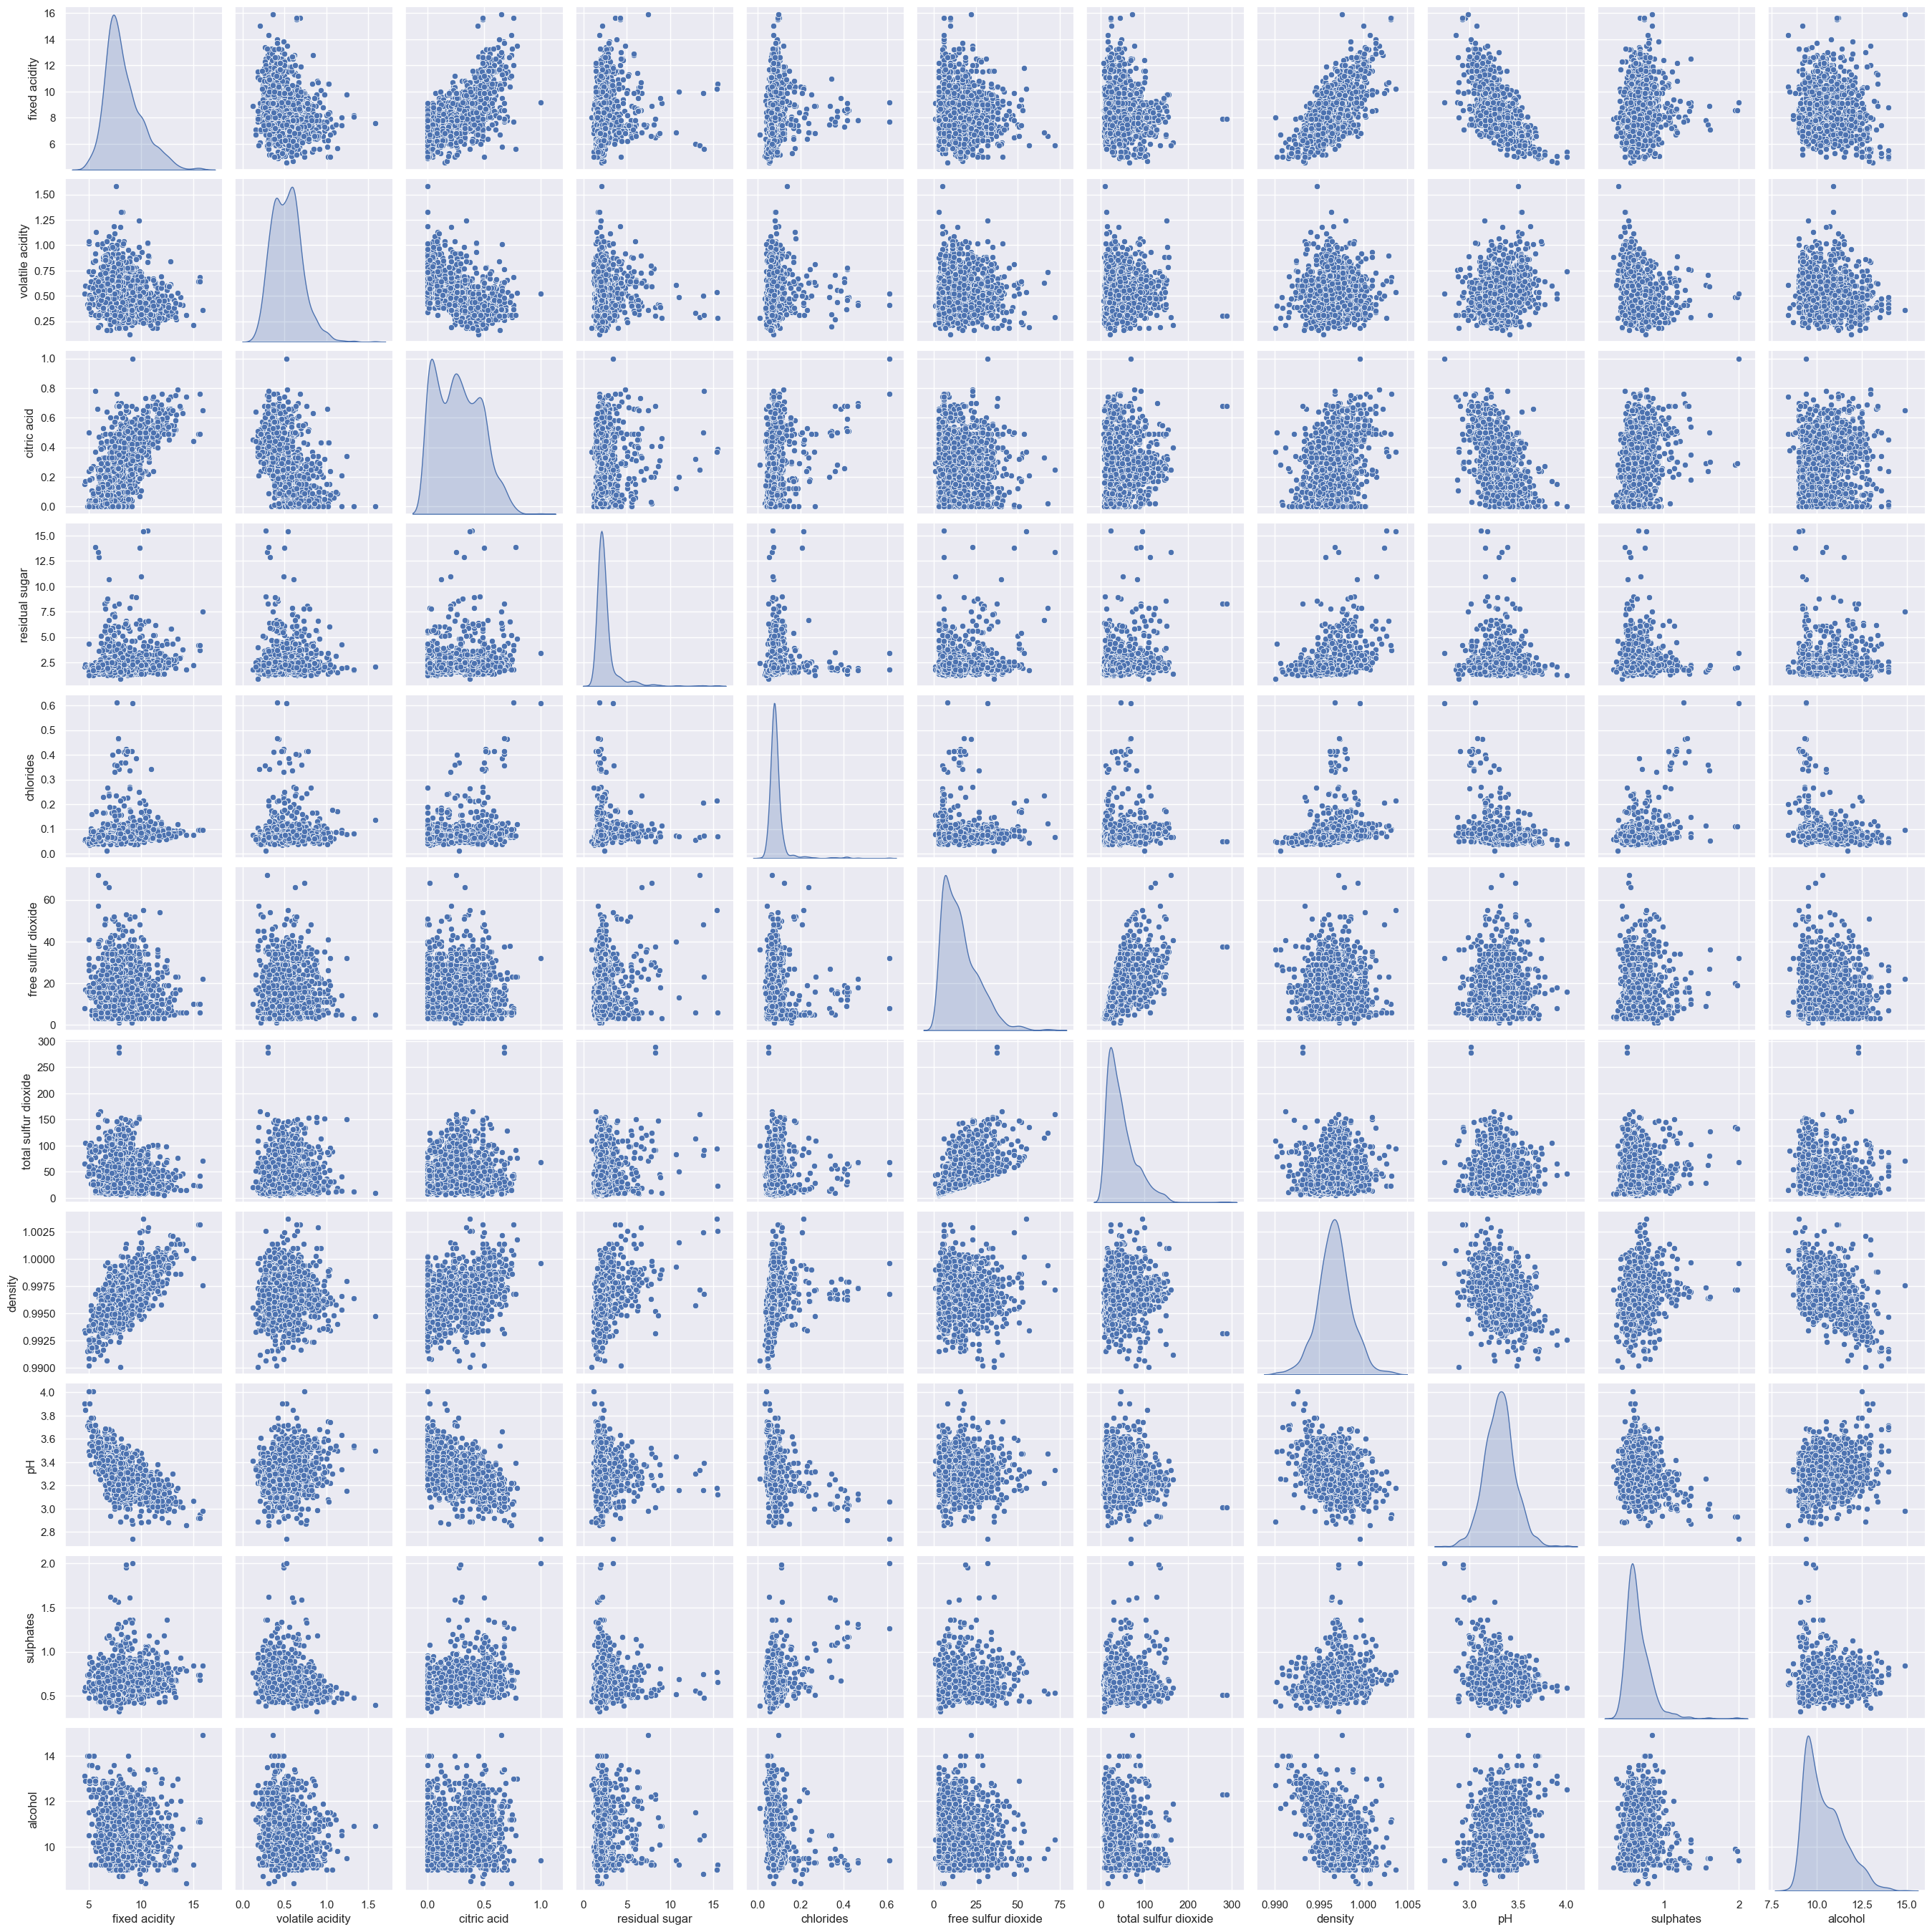

In [157]:
sns.pairplot(model_data.drop(columns=['quality']), diag_kind='kde')
plt.show()

### Begin Data Cleaning

Here we begin to clean the data. The first step will be to deal with the apparent collinearity amongst some of the features as noted above. Some of this seems to obviously come from feature redundancy - i.e., Total Sulfur Dioxide will contain Free Sulfur Dioxide as a summand and there is therefore some redundancy there. Likewise, Citric Acid is itself one of the main components of Fixed Acidity. There are a few other features, like Density and pH, that show collinearity with various features as well. Once we drop these features from the data set, we can revisualize correlations and note that no feature pair-wise correlation remains with an absolute value > 0.37.

Note that there is a secondary benefit to removing the collinear and redundant features. Some of the algorithms we could and will use to model the data, like KNN, are known to have a curse of dimensionality, whereby with a large dimensionlity of features, the distance between nearest and furthest neighbors becomes muddled and almost indistinguishable.

[Text(0.5, 1, 'fixed acidity'),
 Text(1.5, 1, 'volatile acidity'),
 Text(2.5, 1, 'residual sugar'),
 Text(3.5, 1, 'chlorides'),
 Text(4.5, 1, 'total sulfur dioxide'),
 Text(5.5, 1, 'sulphates'),
 Text(6.5, 1, 'alcohol')]

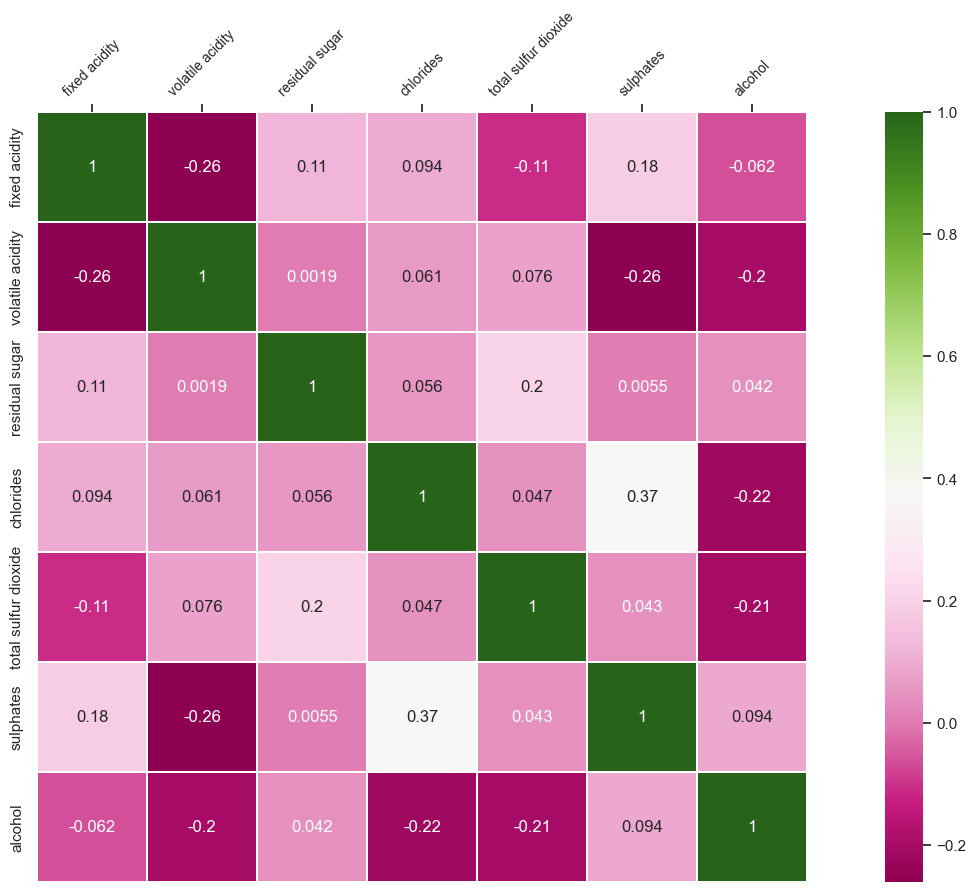

In [158]:
# Start data cleaning

# Drop redundant features and/or other features showing issues of collinearity
model_data = model_data.drop(columns=['citric acid'])
model_data = model_data.drop(columns=['free sulfur dioxide'])
model_data = model_data.drop(columns=['density'])
model_data = model_data.drop(columns=['pH'])

# Revisualize correlation to check we resolved these issues
plt.figure(figsize = (20,10))
sns.set(font_scale=1)
ax = sns.heatmap(model_data.drop(columns=['quality']).corr(), annot=True, cmap="PiYG", annot_kws={"size":12}, square=True, 
        linewidths=0.1)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 10)

### Continue Data Cleaning

We will continue now with some final data cleaning. As noted above, a number of the features (even remaining after the drops above) would appear to be brought closer to normally distributed after a log-transform, and so we first perform that here. After separating the features and target, we finally apply min-max scaling to the features, which is an integral step to modeling the data with algorithms such as k-Nearest-Neighbors.

In [159]:
# Transform the features
model_data['fixed acidity'] = np.log(model_data['fixed acidity'])
model_data['volatile acidity'] = np.log(model_data['volatile acidity'])
model_data['residual sugar'] = np.log(model_data['residual sugar'])
model_data['chlorides'] = np.log(model_data['chlorides'])
model_data['total sulfur dioxide'] = np.log(model_data['total sulfur dioxide'])
model_data['sulphates'] = np.log(model_data['sulphates'])
model_data['alcohol'] = np.log(model_data['alcohol'])

# Split off the target
model_target = model_data.quality
model_data = model_data.drop(columns=['quality'])

# Normalize the features
scaler = MinMaxScaler()
scaler.fit(model_data)
#model_data_scaled = scaler.transform(model_data)
model_data_scaled = pd.DataFrame(scaler.transform(model_data), columns=model_data.columns, index=model_data.index)
print(model_data_scaled.head())
model_data_scaled.info()

   fixed acidity  volatile acidity  residual sugar  chlorides  \
0       0.383325          0.684174        0.262530   0.469653   
1       0.425771          0.772952        0.372733   0.534341   
2       0.425771          0.716078        0.329657   0.518265   
3       0.717475          0.328705        0.262530   0.466283   
4       0.383325          0.684174        0.262530   0.469653   

   total sulfur dioxide  sulphates   alcohol  
0              0.447677   0.293507  0.196252  
1              0.622746   0.401263  0.268963  
2              0.567074   0.376222  0.268963  
3              0.594267   0.312983  0.268963  
4              0.447677   0.293507  0.196252  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   residual sug

### Final Sniff Test of Cleaned Data

Finally, let's look at another pair plot after all the cleaning and feature sclaing/transformations above. We see that all features have now been normalized to the interval [0, 1], are approximately normally distributed, and show no signs of string collinearity.

C:\Program Files\Python39\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


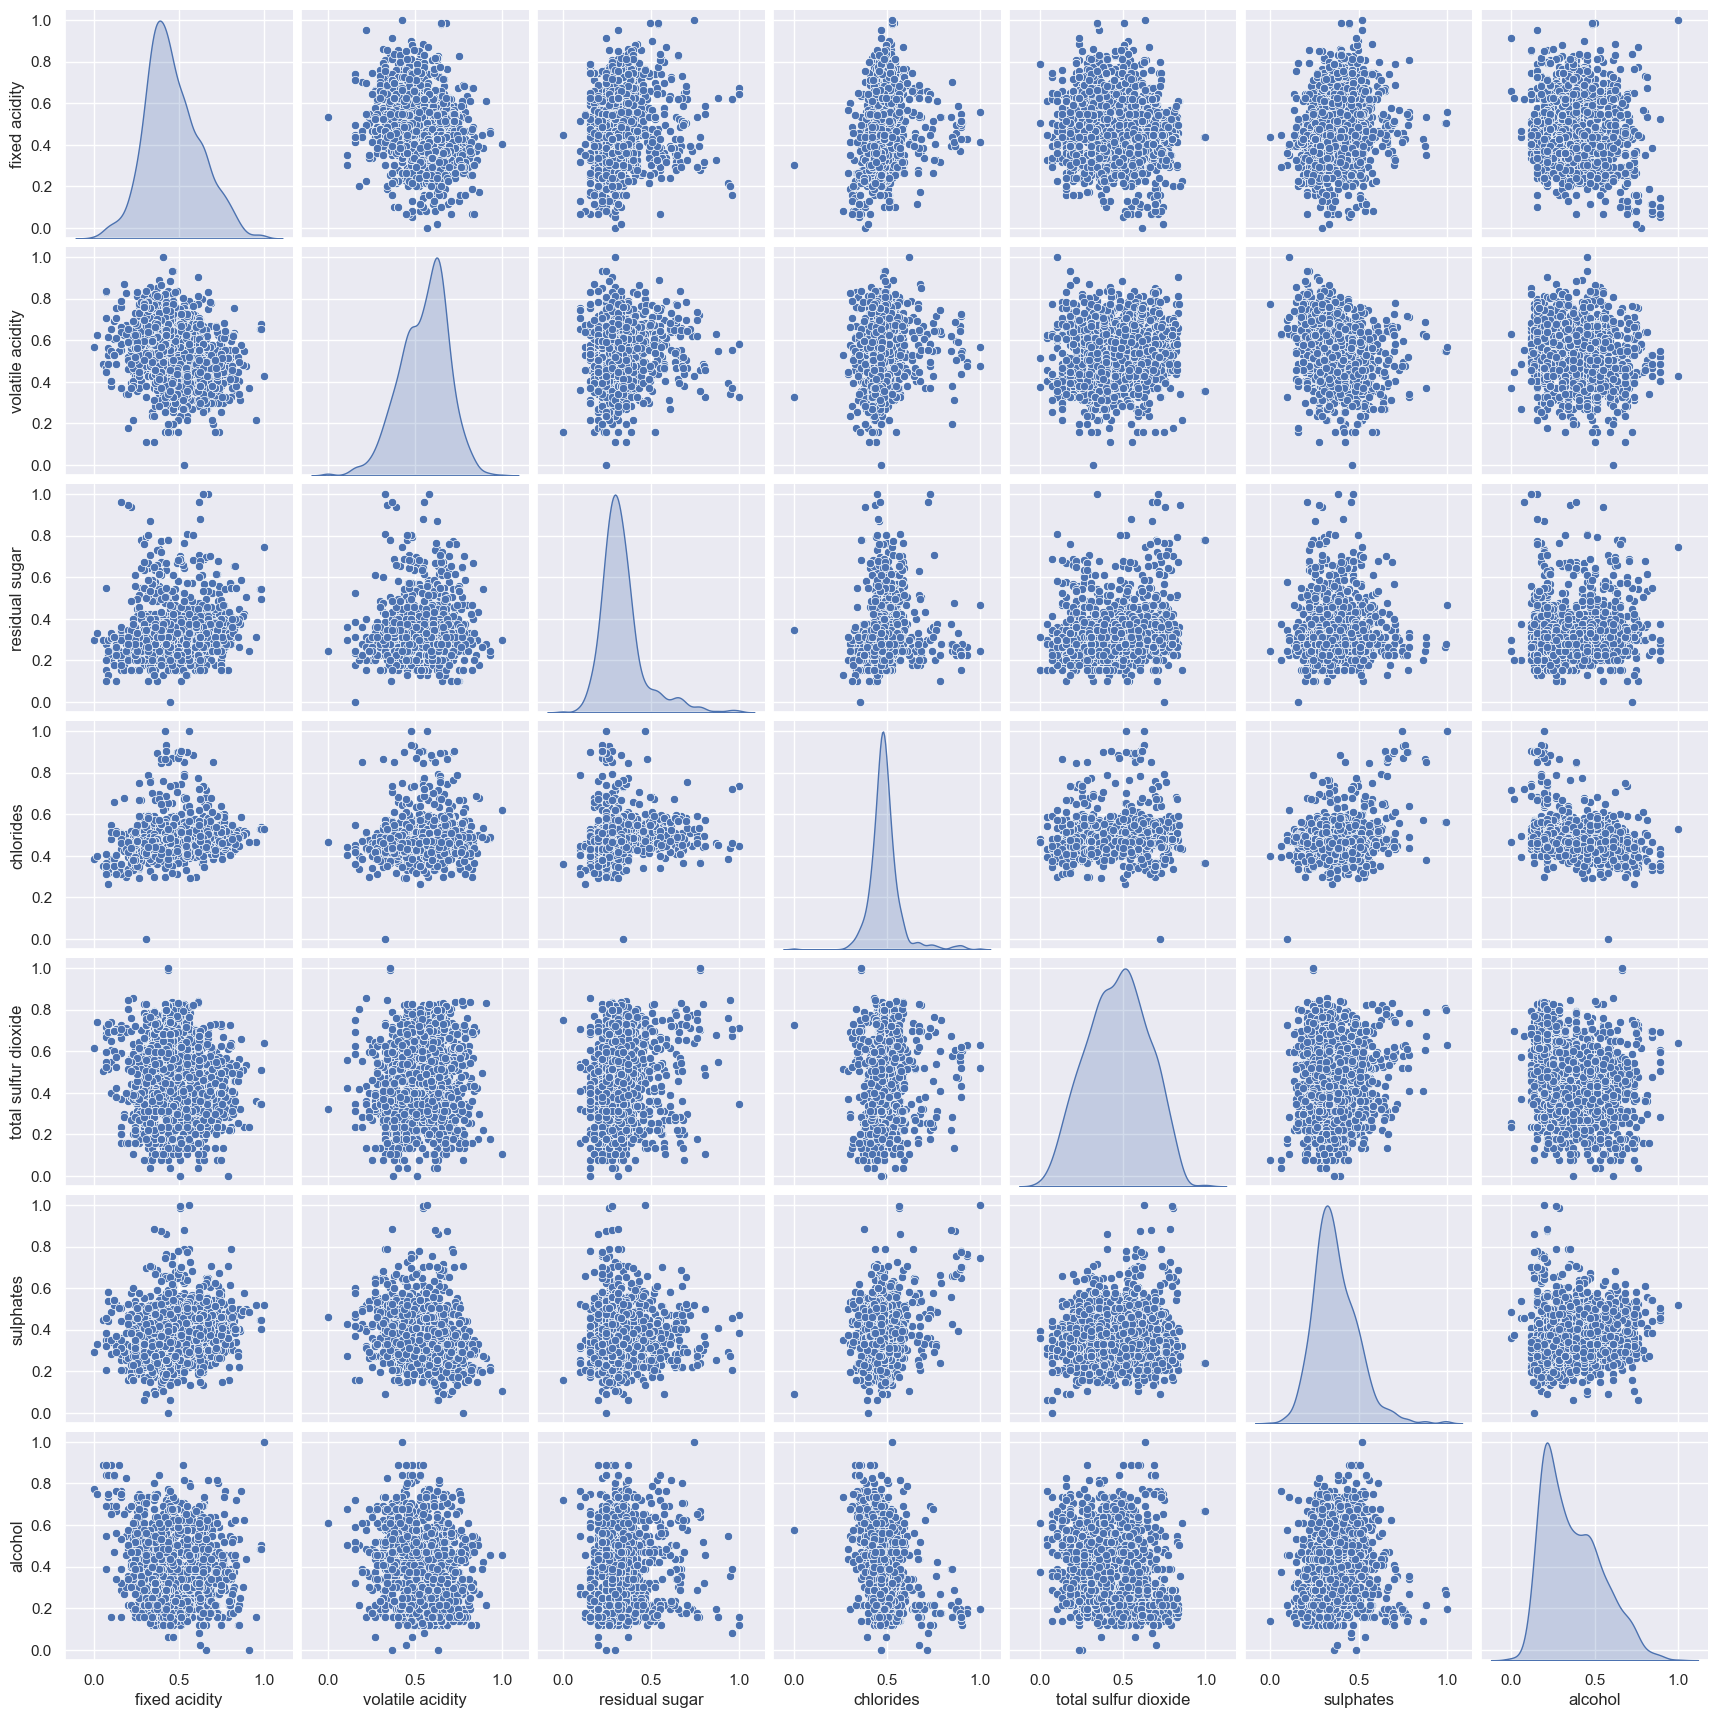

In [160]:
sns.pairplot(model_data_scaled, diag_kind='kde')
plt.show()

In [161]:
# Set Up Training Data
# This line may seem like a trivial rename of objects above, and it is. I went this route later and did not
# want to take the time to rename everything throughout the rest of the notebook.
X_train, y_train = model_data_scaled, model_target


In [162]:
# Define some model assessment helpers

def calculate_precision(y_true, y_pred):
    return sklearn.metrics.precision_score(y_true, y_pred, average=None)

def calculate_recall(y_true, y_pred):
    return sklearn.metrics.recall_score(y_true, y_pred, average=None)

def calculate_accuracy(y_true, y_pred):
    return sklearn.metrics.accuracy_score(y_true, y_pred)

# Model 1
### KNN using Stratified k-Fold Cross-Validation

Let's start training our first classification model, K-Nearest-Neighbors, and due to the heavily imbalanced target data noted above, we are going to use stratified k-Fold cross validation throughout. Stratification essentially means that testing blocks will maintain overall proportions of target classes, so that we don't get testing blocks that coincidentally result in unrealistic (meaning when compared to the full population/sample) representation of some target class/es.

#### Base Model with 5 Nearest-Neighbors

Let's just start with a model that arbitrarily chooses 5 as the number of neighbors. We'll find here that while this model certainly does better than a random guess (as noted above this should be thought of as more like 40% due to our heavily imbalanced data), the precision and recall for the lowest and highest quality classes is quite poor. Given that for this application false negatives are not catastrophic (i.e. cancer diagnoses) we will hope to at least increase our precision in later models.

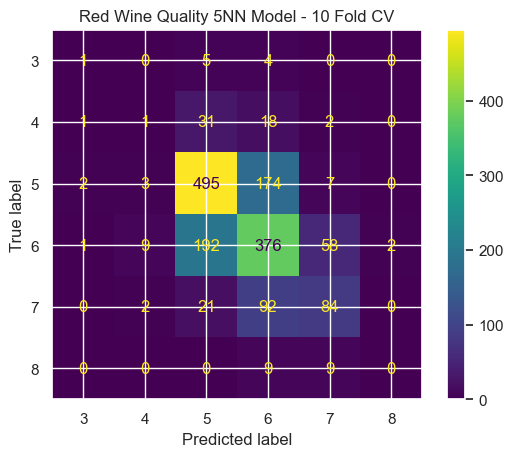

Red Wine Quality 5NN Model 10FCV Accuracy: 0.5984990619136961
Red Wine Quality 5NN Model 10FCV Precision: [0.2        0.06666667 0.66532258 0.55869242 0.525      0.        ]
Red Wine Quality 5NN Model 10FCV Recall: [0.1        0.01886792 0.72687225 0.58934169 0.42211055 0.        ]


In [163]:
# KNN using stratified k-fold cross-validation
# Create StratifiedKFold object. We do this now to fairly use the same splits throughout models below.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
skf_split = skf.split(X_train, y_train)

# Base model with arbitrarily chosen 5 neighbors
knn_cv = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')

y_test_skf = []
y_pred_skf = []
  
for train_index, test_index in skf_split:
    x_train_fold, x_test_fold = np.array(X_train)[train_index], np.array(X_train)[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    knn_cv.fit(x_train_fold, y_train_fold)
    # Store predictions and targets for later assessment
    knn_pred = knn_cv.predict(x_test_fold)
    y_pred_skf.extend(knn_pred)
    y_test_skf.extend(y_test_fold)

model_classes = knn_cv.classes_
cnf_pred = sklearn.metrics.confusion_matrix(y_test_skf, y_pred_skf, labels=model_classes)
disp = ConfusionMatrixDisplay(cnf_pred, display_labels=model_classes)
disp.plot()
plt.title("Red Wine Quality 5NN Model - 10 Fold CV")
plt.show()
# Check accuracy statistics
prec1 = calculate_precision(y_test_skf, y_pred_skf)
recall1 = calculate_recall(y_test_skf, y_pred_skf)
acc1 = calculate_accuracy(y_test_skf, y_pred_skf)
print(f'Red Wine Quality 5NN Model 10FCV Accuracy: {acc1}')
print(f'Red Wine Quality 5NN Model 10FCV Precision: {prec1}')
print(f'Red Wine Quality 5NN Model 10FCV Recall: {recall1}')

#### Grid Search for Optimal Neighbors

Now let's refine the choice of neighbors to use. We can use the GridSearchCV() method here, and note that we define the cv argument as the same StratifiedKFold class instance we used above. In the end we can also graph the entire accuracy curve for the range of k neighbors we searched. The results here are a bit interesting. First, the most accurate model is arguably the most extreme variance model of only the single nearest neighbor. However, this may make sense due to the heavily imbalanced data. We see that beyond that, the range of choices from 2 - 25 has rather little effect on the resulting accuracy (the apparent variation is more an illusion due to the range/scale of the y-axis). As more neighbors are added to the distance metric, you quickly just start averaging over the more represented classes. It's also hard to know how the dimensionality of our features is muddling the model, although we at least tried to remedy this to a degree by removing collinear and redundant features in our data cleaning steps.

kFCV Best K: {'n_neighbors': 1}
kFCV Best Score: 0.6629048742138365


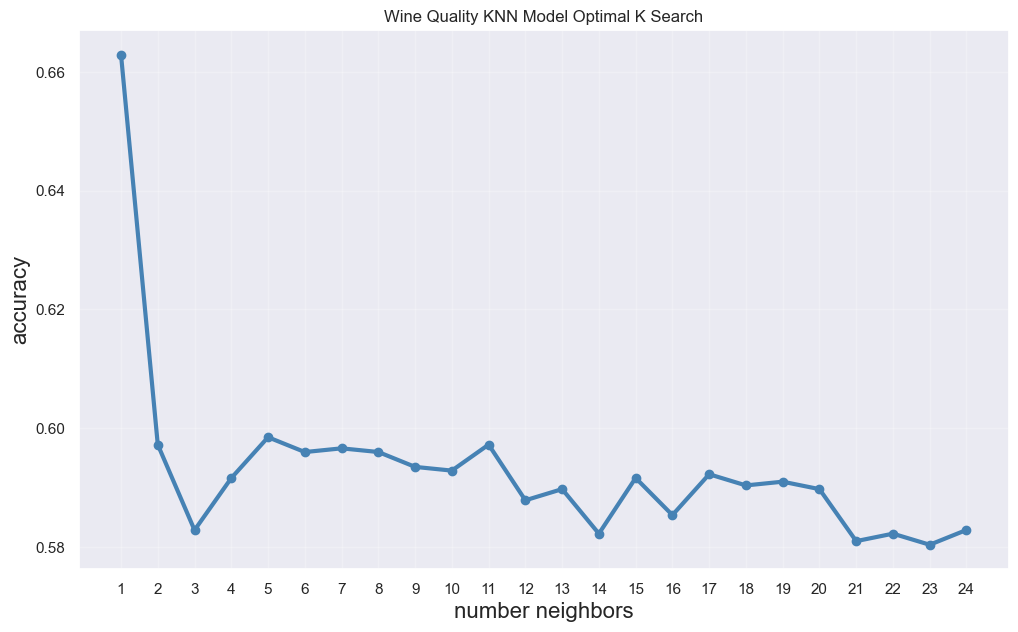

In [164]:
# Define base class/model (do note define neighbors)
knn2 = KNeighborsClassifier(algorithm='ball_tree')

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}

#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=1))

#fit model to data
knn_gscv.fit(X_train, y_train)
print(f'kFCV Best K: {knn_gscv.best_params_}')
print(f'kFCV Best Score: {knn_gscv.best_score_}')

# Graphs the whole param curve
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(range(1,25), knn_gscv.cv_results_['mean_test_score'], marker="o", color="steelblue", lw=3, label="unweighted")
ax.set_xlabel("number neighbors", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
plt.xticks(range(1,25))
plt.title("Wine Quality KNN Model Optimal K Search")
ax.grid(alpha=0.25)

#### Inspect Confusion Matrix for Optimal Model

Although it probably wouldn't be a great idea to use a 1-neighbor model in general, let's go ahead and take a look at the resulting confusion matrix. We do see here that you do finally get non-zero values for both precision and recall for the highest quality 8 class, however the values still leave a lot to be desired along with the lowest quality 3 class maintaining similar poor performance.

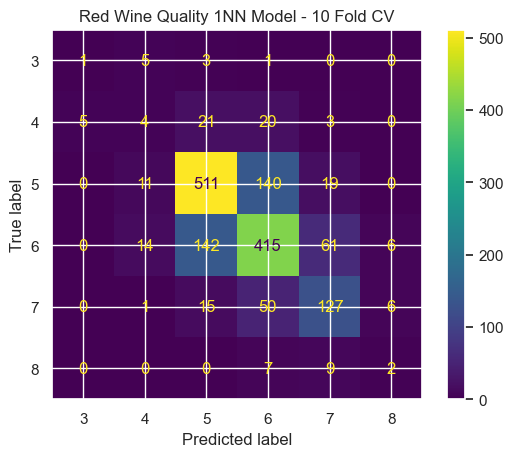

Red Wine Quality 1NN Model 10FCV Accuracy: 0.6629143214509068
Red Wine Quality 1NN Model 10FCV Precision: [0.16666667 0.11428571 0.73843931 0.65560821 0.57990868 0.14285714]
Red Wine Quality 1NN Model 10FCV Recall: [0.1        0.0754717  0.75036711 0.65047022 0.63819095 0.11111111]


In [165]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
skf_split = skf.split(X_train, y_train)
knn_cv = KNeighborsClassifier(n_neighbors=1, algorithm='ball_tree')
y_test_skf = []
y_pred_skf = []
  
for train_index, test_index in skf_split:
    x_train_fold, x_test_fold = np.array(X_train)[train_index], np.array(X_train)[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    knn_cv.fit(x_train_fold, y_train_fold)
    # Store predictions and targets for later assessment
    knn_pred = knn_cv.predict(x_test_fold)
    y_pred_skf.extend(knn_pred)
    y_test_skf.extend(y_test_fold)

cnf_pred = sklearn.metrics.confusion_matrix(y_test_skf, y_pred_skf, labels=model_classes)
disp = ConfusionMatrixDisplay(cnf_pred, display_labels=model_classes)
disp.plot()
plt.title("Red Wine Quality 1NN Model - 10 Fold CV")
plt.show()
# Check accuracy statistics
prec1 = calculate_precision(y_test_skf, y_pred_skf)
recall1 = calculate_recall(y_test_skf, y_pred_skf)
acc1 = calculate_accuracy(y_test_skf, y_pred_skf)
print(f'Red Wine Quality 1NN Model 10FCV Accuracy: {acc1}')
print(f'Red Wine Quality 1NN Model 10FCV Precision: {prec1}')
print(f'Red Wine Quality 1NN Model 10FCV Recall: {recall1}')

# Model 2
### Decision Tree Classifier using Stratified k-Fold Cross-Validation

Let's move on to another classification model, a decision tree. This will also set us up nicely to use this as a base class (in stump form) for a later boosting algorithm given the imabalanced data issue. We first define a sort of helper class below that was cloned from a class exercise.

In [166]:
# Build decision tree classifier

def build_dt(data_X, data_y, max_depth = None, max_leaf_nodes = None, ccp_alpha=0.0):
    
    # Create Decision Tree classifer object
    clf = DecisionTreeClassifier(max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, ccp_alpha=ccp_alpha)

    # Train Decision Tree Classifer
    clf = clf.fit(data_X, data_y)
    
    return clf

#### Stump Tree

Let's start with a stumpt tree with a depth of 1. While we do not expect this to be a well performing model, we're hoping to still see accuracy here of better than random which will be a good foundation for a subsequent boosting algorithm. We do find this, although note what we have here with a stump tree is really on trying to differentiate between the two most common classes.

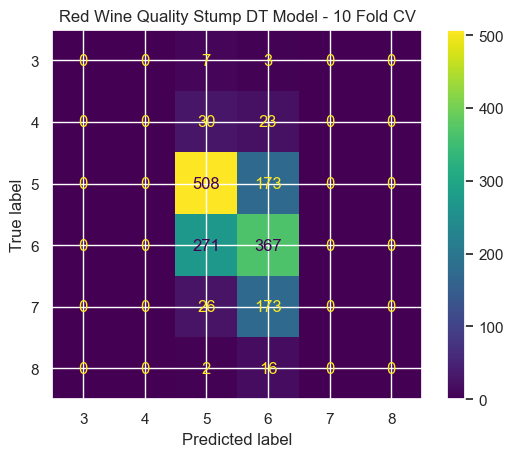

Red Wine Quality Stump DT Model 10FCV Accuracy: 0.5472170106316447
Red Wine Quality Stump DT Model 10FCV Precision: [0.         0.         0.60189573 0.48609272 0.         0.        ]
Red Wine Quality Stump DT Model 10FCV Recall: [0.         0.         0.74596182 0.57523511 0.         0.        ]


C:\Program Files\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [167]:
# Build a stump dt
# Stump decision tree using stratified k-fold cross-validation
# Create StratifiedKFold object. We do this now to fairly use the same splits throughout models below.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
skf_split = skf.split(X_train, y_train)

y_test_skf = []
y_pred_skf = []
  
for train_index, test_index in skf_split:
    x_train_fold, x_test_fold = np.array(X_train)[train_index], np.array(X_train)[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    dt = build_dt(x_train_fold, y_train_fold, max_depth=1)
    # Store predictions and targets for later assessment
    dt_pred = dt.predict(x_test_fold)
    y_pred_skf.extend(dt_pred)
    y_test_skf.extend(y_test_fold)

model_classes = dt.classes_
cnf_pred = sklearn.metrics.confusion_matrix(y_test_skf, y_pred_skf, labels=model_classes)
disp = ConfusionMatrixDisplay(cnf_pred, display_labels=model_classes)
disp.plot()
plt.title("Red Wine Quality Stump DT Model - 10 Fold CV")
plt.show()
# Check accuracy statistics
prec1 = calculate_precision(y_test_skf, y_pred_skf)
recall1 = calculate_recall(y_test_skf, y_pred_skf)
acc1 = calculate_accuracy(y_test_skf, y_pred_skf)
print(f'Red Wine Quality Stump DT Model 10FCV Accuracy: {acc1}')
print(f'Red Wine Quality Stump DT Model 10FCV Precision: {prec1}')
print(f'Red Wine Quality Stump DT Model 10FCV Recall: {recall1}')

#### Optimal Depth Tree Search

Let's take a look at searchig for an optimal depth of the tree. Let's also introduce a new concept here of defining a custom cost function for the GridSearch() method (it defaults to just typical accuracy score, which may not be ideal or desired. See the "scoring" optional argument used below). However, here we find that there isn't a whole lot of difference between what appears to be an optimal model based on accuracy vs (custom) precision score. We'll take it to be 20 as we move on to the next section of running an optimal depth model.


kFCV Best Depth: {'max_depth': 20}
kFCV Best Score: 0.6354048742138365


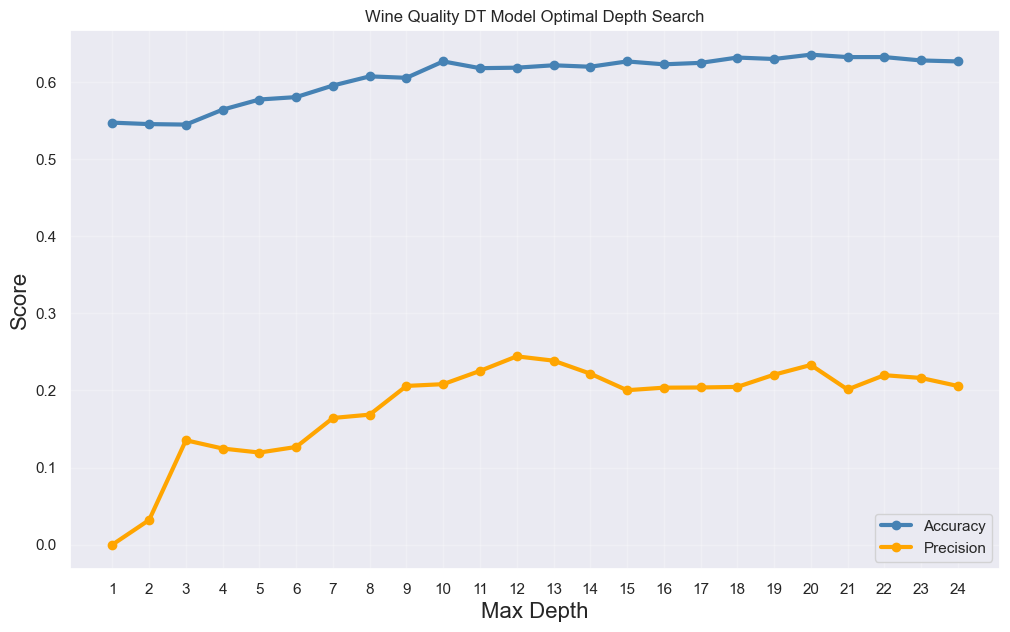

In [168]:
def custom_precision_function(y_true, y_pred):
    precision = sklearn.metrics.precision_score(y_true, y_pred, average=None, zero_division=0)
    return np.mean(precision[[0,1,4,5]])

# Accuracy based
# Define base class/model (do note define neighbors)
dt = DecisionTreeClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'max_depth': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
dt_gscv = GridSearchCV(dt, param_grid, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=1))
#fit model to data
dt_gscv.fit(X_train, y_train)
print(f'kFCV Best Depth: {dt_gscv.best_params_}')
print(f'kFCV Best Score: {dt_gscv.best_score_}')

# Custom precision score based
custom_scorer = make_scorer(custom_precision_function, greater_is_better=True)
# Define base class/model (do note define neighbors)
dt = DecisionTreeClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'max_depth': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
dt_gscv_custom = GridSearchCV(dt, param_grid, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=1), scoring=custom_scorer)
#fit model to data
dt_gscv_custom.fit(X_train, y_train)

# Graphs the whole param curve
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(range(1,25), dt_gscv.cv_results_['mean_test_score'], marker="o", color="steelblue", lw=3, label="unweighted")
ax.plot(range(1,25), dt_gscv_custom.cv_results_['mean_test_score'], marker="o", color="orange", lw=3, label="unweighted")
ax.set_xlabel("Max Depth", fontsize=16)
ax.set_ylabel("Score", fontsize=16)
plt.xticks(range(1,25))
plt.title("Wine Quality DT Model Optimal Depth Search")
plt.legend(["Accuracy", "Precision"], loc="lower right")
ax.grid(alpha=0.25)

#### Optimal Depth Tree Run

Let's now run the tree with the depth of 20 found above. We do find an incremental improvement on everything else we've done thus far above - achieving an accuracy over 60% but also with improved precision (as well as recall).

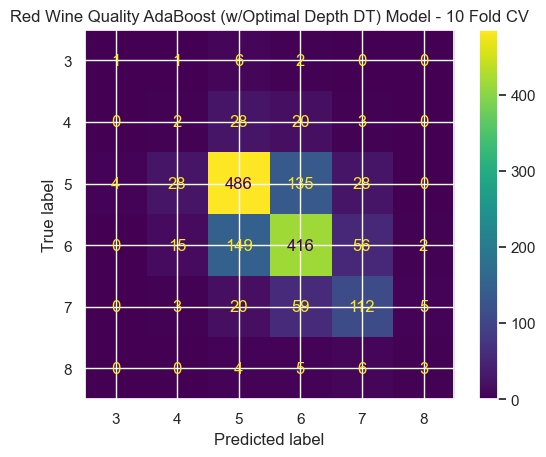

Red Wine Quality Adaboost (w/Optimal Depth DT) Model 10FCV Accuracy: 0.6378986866791745
Red Wine Quality Adaboost (w/Optimal Depth DT) Model 10FCV Precision: [0.2        0.04081633 0.7012987  0.65306122 0.54634146 0.3       ]
Red Wine Quality Adaboost (w/Optimal Depth DT) Model 10FCV Recall: [0.1        0.03773585 0.71365639 0.65203762 0.56281407 0.16666667]


In [169]:
# Run Optimal DT Model

# Create StratifiedKFold object. We do this now to fairly use the same splits throughout models below.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
skf_split = skf.split(X_train, y_train)

y_test_skf = []
y_pred_skf = []
  
for train_index, test_index in skf_split:
    x_train_fold, x_test_fold = np.array(X_train)[train_index], np.array(X_train)[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    dt = DecisionTreeClassifier(max_depth=20)
    clf = AdaBoostClassifier(n_estimators=100, estimator=dt, learning_rate=1, random_state=1, algorithm='SAMME')
    clf.fit(x_train_fold, y_train_fold)
    # Store predictions and targets for later assessment
    dt_pred = clf.predict(x_test_fold)
    y_pred_skf.extend(dt_pred)
    y_test_skf.extend(y_test_fold)

model_classes = clf.classes_
cnf_pred = sklearn.metrics.confusion_matrix(y_test_skf, y_pred_skf, labels=model_classes)
disp = ConfusionMatrixDisplay(cnf_pred, display_labels=model_classes)
disp.plot()
plt.title("Red Wine Quality AdaBoost (w/Optimal Depth DT) Model - 10 Fold CV")
plt.show()
# Check accuracy statistics
prec1 = calculate_precision(y_test_skf, y_pred_skf)
recall1 = calculate_recall(y_test_skf, y_pred_skf)
acc1 = calculate_accuracy(y_test_skf, y_pred_skf)
print(f'Red Wine Quality Adaboost (w/Optimal Depth DT) Model 10FCV Accuracy: {acc1}')
print(f'Red Wine Quality Adaboost (w/Optimal Depth DT) Model 10FCV Precision: {prec1}')
print(f'Red Wine Quality Adaboost (w/Optimal Depth DT) Model 10FCV Recall: {recall1}')

# Model 3
### AdaBoosted Decision Tree Classifier using Stratified k-Fold Cross-Validation

Now let's look at one final model/algorithm - AdaBoost using a stump decision tree as its base. We're hoping this is a way to better deal with the imbalanced data. While the addition of the boosting logic does improve the classification of the under-represented classes vs the raw stump model ran above, overall the model is not a great performer.

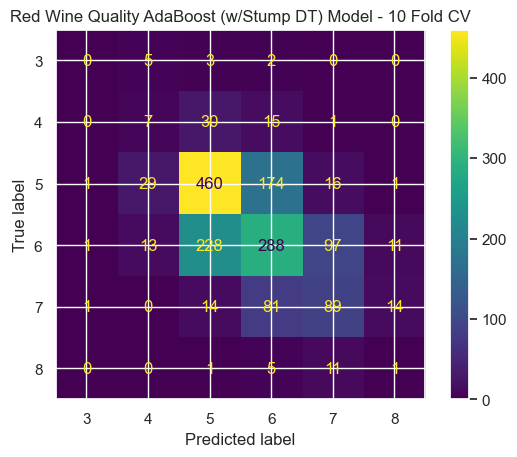

Red Wine Quality Adaboost (w/Stump DT) Model 10FCV Accuracy: 0.5284552845528455
Red Wine Quality Adaboost (w/Stump DT) Model 10FCV Precision: [0.         0.12962963 0.625      0.50973451 0.41588785 0.03703704]
Red Wine Quality Adaboost (w/Stump DT) Model 10FCV Recall: [0.         0.13207547 0.67547724 0.45141066 0.44723618 0.05555556]


In [170]:
# Run AdaBoost

# Stump decision tree classifier

# Create StratifiedKFold object. We do this now to fairly use the same splits throughout models below.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
skf_split = skf.split(X_train, y_train)

y_test_skf = []
y_pred_skf = []
  
for train_index, test_index in skf_split:
    x_train_fold, x_test_fold = np.array(X_train)[train_index], np.array(X_train)[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    dt = DecisionTreeClassifier(max_depth=1)
    clf = AdaBoostClassifier(n_estimators=100, estimator=dt, learning_rate=1, random_state=1, algorithm='SAMME')
    clf.fit(x_train_fold, y_train_fold)
    # Store predictions and targets for later assessment
    dt_pred = clf.predict(x_test_fold)
    y_pred_skf.extend(dt_pred)
    y_test_skf.extend(y_test_fold)

model_classes = clf.classes_
cnf_pred = sklearn.metrics.confusion_matrix(y_test_skf, y_pred_skf, labels=model_classes)
disp = ConfusionMatrixDisplay(cnf_pred, display_labels=model_classes)
disp.plot()
plt.title("Red Wine Quality AdaBoost (w/Stump DT) Model - 10 Fold CV")
plt.show()
# Check accuracy statistics
prec1 = calculate_precision(y_test_skf, y_pred_skf)
recall1 = calculate_recall(y_test_skf, y_pred_skf)
acc1 = calculate_accuracy(y_test_skf, y_pred_skf)
print(f'Red Wine Quality Adaboost (w/Stump DT) Model 10FCV Accuracy: {acc1}')
print(f'Red Wine Quality Adaboost (w/Stump DT) Model 10FCV Precision: {prec1}')
print(f'Red Wine Quality Adaboost (w/Stump DT) Model 10FCV Recall: {recall1}')


#### AdaBoost Optimal Depth Search

Finally, let's do something that is not typical practice - looking for a deeper tree in an AdaBoosted setting. While the whole idea of boosting is typically to use weak learners as the base models, it could be interesting to see if something still with a relatively low depth (so not meaning the depth of 20 we found before, but greater than the 1 stump we just used) can significantly improve our results here.

kFCV Best Depth: {'estimator': DecisionTreeClassifier(max_depth=9)}
kFCV Best Score: 0.712936320754717


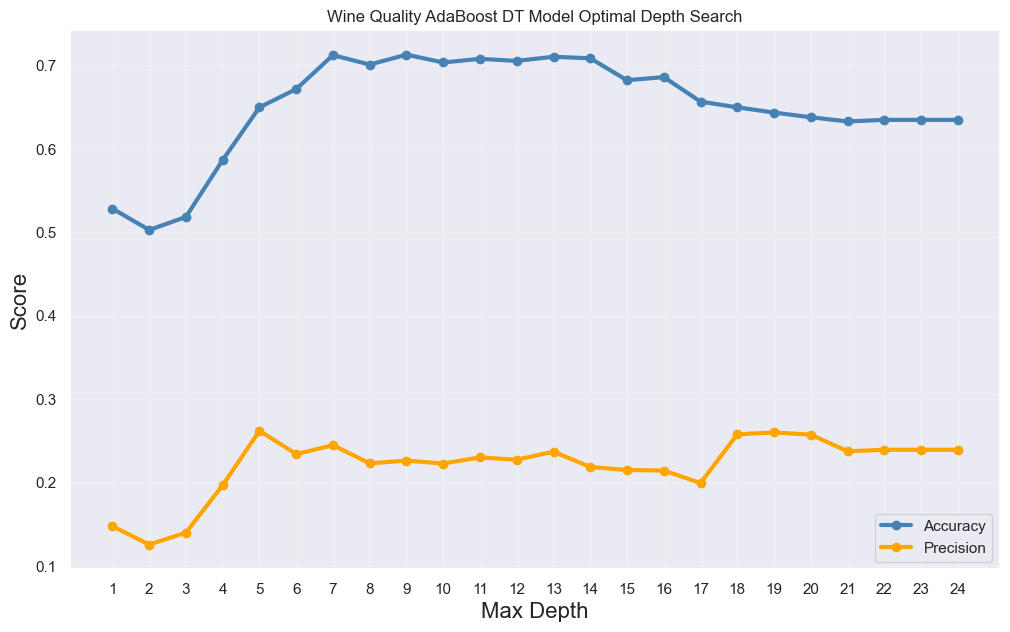

In [171]:
# Define base class/model (do note define neighbors)
dt_vector = [DecisionTreeClassifier(max_depth=i) for i in np.arange(1, 25)]
clf = AdaBoostClassifier(n_estimators=100, learning_rate=1, random_state=1, algorithm='SAMME')
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'estimator': dt_vector}

# Accuracy based
#use gridsearch to test all values for n_neighbors
dt_gscv = GridSearchCV(clf, param_grid, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=1))
#fit model to data
dt_gscv.fit(X_train, y_train)
print(f'kFCV Best Depth: {dt_gscv.best_params_}')
print(f'kFCV Best Score: {dt_gscv.best_score_}')

# Custom precision score based
#use gridsearch to test all values for n_neighbors
dt_gscv_custom = GridSearchCV(clf, param_grid, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=1), scoring=custom_scorer)
#fit model to data
dt_gscv_custom.fit(X_train, y_train)

# Graphs the whole param curve
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(range(1,25), dt_gscv.cv_results_['mean_test_score'], marker="o", color="steelblue", lw=3, label="unweighted")
ax.plot(range(1,25), dt_gscv_custom.cv_results_['mean_test_score'], marker="o", color="orange", lw=3, label="unweighted")
ax.set_xlabel("Max Depth", fontsize=16)
ax.set_ylabel("Score", fontsize=16)
plt.xticks(range(1,25))
plt.title("Wine Quality AdaBoost DT Model Optimal Depth Search")
plt.legend(["Accuracy", "Precision"], loc="lower right")
ax.grid(alpha=0.25)

#### AdaBoost Optimal Depth Run

Let's now run the optimal model found above. Although the output told us 9 was the best model based on accuracy, let's actually run with 7 given that it actually achieved a better score based on the custom precision metric and also has the methodological benefit of being a relatively weaker learner. Here we now have a model with over 70% accuracy, and also something we haven't seen yet which is a 50% precision score for one of the under-represented classes, in particular the highest quality wine. However, we do see that this model does not in fact have any non-zero precision or recall for the two lowest quality wine classes. This result is still interesting - imagine you in fact do not care about false negatives and just want to drink high quality wines with a large degree of confidence. Such a model that performs relatively better on precisely classifiying higher quality wines would be exactly the bias you'd want in your model.

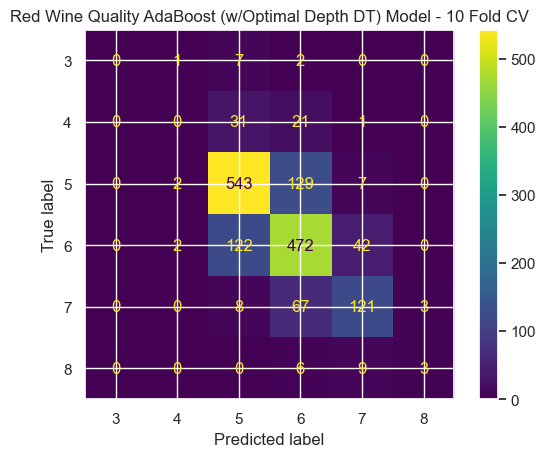

Red Wine Quality Adaboost (w/Optimal Depth DT) Model 10FCV Accuracy: 0.7123202001250781
Red Wine Quality Adaboost (w/Optimal Depth DT) Model 10FCV Precision: [0.         0.         0.76371308 0.67718795 0.67222222 0.5       ]
Red Wine Quality Adaboost (w/Optimal Depth DT) Model 10FCV Recall: [0.         0.         0.79735683 0.73981191 0.6080402  0.16666667]


C:\Program Files\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [172]:
# Run Optimal AdaBoost Model

# Stump decision tree classifier

# Create StratifiedKFold object. We do this now to fairly use the same splits throughout models below.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
skf_split = skf.split(X_train, y_train)

y_test_skf = []
y_pred_skf = []
  
for train_index, test_index in skf_split:
    x_train_fold, x_test_fold = np.array(X_train)[train_index], np.array(X_train)[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    dt = DecisionTreeClassifier(max_depth=7)
    clf = AdaBoostClassifier(n_estimators=100, estimator=dt, learning_rate=1, random_state=1, algorithm='SAMME')
    clf.fit(x_train_fold, y_train_fold)
    # Store predictions and targets for later assessment
    dt_pred = clf.predict(x_test_fold)
    y_pred_skf.extend(dt_pred)
    y_test_skf.extend(y_test_fold)

model_classes = clf.classes_
cnf_pred = sklearn.metrics.confusion_matrix(y_test_skf, y_pred_skf, labels=model_classes)
disp = ConfusionMatrixDisplay(cnf_pred, display_labels=model_classes)
disp.plot()
plt.title("Red Wine Quality AdaBoost (w/Optimal Depth DT) Model - 10 Fold CV")
plt.show()
# Check accuracy statistics
prec1 = calculate_precision(y_test_skf, y_pred_skf)
recall1 = calculate_recall(y_test_skf, y_pred_skf)
acc1 = calculate_accuracy(y_test_skf, y_pred_skf)
print(f'Red Wine Quality Adaboost (w/Optimal Depth DT) Model 10FCV Accuracy: {acc1}')
print(f'Red Wine Quality Adaboost (w/Optimal Depth DT) Model 10FCV Precision: {prec1}')
print(f'Red Wine Quality Adaboost (w/Optimal Depth DT) Model 10FCV Recall: {recall1}')